In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib, json, os
import shap


In [2]:
# Upload file or set path
# If you used files.upload() earlier, replace path accordingly
csv_path = '/content/titanic.csv'   # adjust if filename differs
df = pd.read_csv(csv_path)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


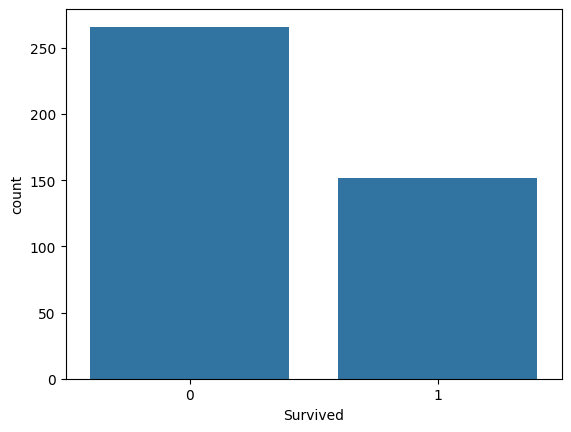

In [3]:
df.info()
df.isnull().sum()
df['Survived'].value_counts(normalize=True)
sns.countplot(x='Survived', data=df); plt.show()


In [4]:
df_fe = df.copy()

# 1) Title extraction from Name
df_fe['Title'] = df_fe['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
# group rare titles
title_map = {
    'Mlle':'Miss','Ms':'Miss','Mme':'Mrs',
    'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare','Don':'Rare','Dr':'Rare','Major':'Rare',
    'Rev':'Rare','Sir':'Rare','Jonkheer':'Rare','Dona':'Rare'
}
df_fe['Title'] = df_fe['Title'].replace(title_map)
# 2) Family size
df_fe['family_size'] = df_fe['SibSp'] + df_fe['Parch'] + 1
# 3) Cabin presence (boolean)
df_fe['cabin_present'] = df_fe['Cabin'].notnull().astype(int)
# 4) Fare per person (optional)
df_fe['fare_per_person'] = df_fe['Fare'] / df_fe['family_size'].replace(0,1)
# 5) Simplify Embarked
df_fe['Embarked'] = df_fe['Embarked'].fillna('S')

df_fe[['Title','family_size','cabin_present','fare_per_person','Embarked']].head()


,Title,family_size,cabin_present,fare_per_person,Embarked
0,Mr,1,0,7.829200,Q
1,Mrs,2,0,3.500000,S
2,Mr,1,0,9.687500,Q
3,Mr,1,0,8.662500,S
4,Mrs,3,0,4.095833,S


In [6]:
# ===== Feature engineering + safe missing-value handling =====
import pandas as pd
import numpy as np

# Work on a copy
df_fe = df.copy()

# 1) Title extraction (from Name) and normalize rare titles
df_fe['Title'] = df_fe['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
df_fe['Title'] = df_fe['Title'].fillna('Unknown')

title_map = {
    'Mlle':'Miss','Ms':'Miss','Mme':'Mrs',
    'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare','Don':'Rare','Dr':'Rare','Major':'Rare',
    'Rev':'Rare','Sir':'Rare','Jonkheer':'Rare','Dona':'Rare'
}
df_fe['Title'] = df_fe['Title'].replace(title_map)

# 2) Family size
df_fe['family_size'] = df_fe['SibSp'].fillna(0).astype(int) + df_fe['Parch'].fillna(0).astype(int) + 1

# 3) Cabin presence (1 if cabin info present, else 0)
df_fe['cabin_present'] = df_fe['Cabin'].notnull().astype(int)

# 4) Fare per person (safe division)
df_fe['Fare'] = pd.to_numeric(df_fe['Fare'], errors='coerce')
df_fe['fare_per_person'] = df_fe['Fare'] / df_fe['family_size'].replace(0,1)
df_fe['fare_per_person'] = df_fe['fare_per_person'].fillna(df_fe['fare_per_person'].median())

# 5) Embarked fill (mode) if column exists
if 'Embarked' in df_fe.columns:
    df_fe['Embarked'] = df_fe['Embarked'].fillna(df_fe['Embarked'].mode().iloc[0])

# 6) Safe Age imputation: median per Title using transform (keeps alignment)
df_fe['Age'] = pd.to_numeric(df_fe['Age'], errors='coerce')   # ensure numeric
df_fe['Age'] = df_fe.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())      # final fallback

# 7) Final checks: show missing counts and sample rows
print("Missing counts (selected cols):")
print(df_fe[['Age','Fare','Embarked','Title','family_size','cabin_present','fare_per_person']].isnull().sum())
print("\nValue counts for Title (top):")
print(df_fe['Title'].value_counts().head(10))

# 8) Prepare features (example set) and target
features = ['Pclass','Sex','Age','Fare','Embarked','Title','family_size','cabin_present','fare_per_person']
features = [c for c in features if c in df_fe.columns]  # keep only existing
X_raw = df_fe[features].copy()
y = df_fe['Survived'] if 'Survived' in df_fe.columns else None

# 9) Quick one-hot encoding for categorical columns (Sex, Embarked, Title)
cat_cols = [c for c in ['Sex','Embarked','Title'] if c in X_raw.columns]
X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)

print("\nFinal feature matrix shape:", X.shape)
display(X.head())


Missing counts (selected cols):
Age                0
Fare               1
Embarked           0
Title              0
family_size        0
cabin_present      0
fare_per_person    0
dtype: int64

Value counts for Title (top):
Title
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: count, dtype: int64

Final feature matrix shape: (418, 13)


,Pclass,Age,Fare,family_size,cabin_present,fare_per_person,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,34.5,7.8292,1,0,7.829200,True,True,False,False,True,False,False
1,3,47.0,7.0000,2,0,3.500000,False,False,True,False,False,True,False
2,2,62.0,9.6875,1,0,9.687500,True,True,False,False,True,False,False
3,3,27.0,8.6625,1,0,8.662500,True,False,True,False,True,False,False
4,3,22.0,12.2875,3,0,4.095833,False,False,True,False,False,True,False


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (334, 13)
Test size: (84, 13)


In [9]:
# === Train, evaluate, pick best model, and SAVE (single cell) ===
import os, joblib, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1) Defensive cleaning: replace infinities and fill remaining NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)
print("Remaining NaN count in X:", X.isnull().sum().sum())

# 2) Train/test split (stratify if y has classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/test shapes:", X_train.shape, X_test.shape)

# 3) Define models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# 4) Train & evaluate
results = []
trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    roc  = roc_auc_score(y_test, probs) if probs is not None else None

    results.append((name, acc, prec, rec, f1, roc))
    trained_models[name] = model
    print(f"{name} -> Acc:{acc:.4f}, Prec:{prec:.4f}, Rec:{rec:.4f}, F1:{f1:.4f}, ROC_AUC:{None if roc is None else roc:.4f}")

# 5) Results table
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"])
results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
print("\nModel comparison (sorted by F1):")
display(results_df)

# 6) Pick best model by F1
best_name = results_df.loc[0, "Model"]
best_model = trained_models[best_name]
print("\nSelected best model:", best_name)

# 7) Save best model and feature names
save_dir = "/content/drive/MyDrive/Alfido/Task3" if os.path.isdir('/content/drive') else '/content'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, f"{best_name}_titanic_model.pkl")
joblib.dump(best_model, model_path)

feat_path = os.path.join(save_dir, "feature_names.json")
with open(feat_path, "w") as f:
    json.dump(list(X.columns), f)

print(f"Saved model to: {model_path}")
print(f"Saved feature list to: {feat_path}")

# 8) Small inference example using saved model (confirm it loads)
loaded = joblib.load(model_path)
with open(feat_path,'r') as f:
    feature_names = json.load(f)

# Build a sample raw input (must be preprocessed same as training)
# Example for Titanic (adjust values as needed)
sample_raw = {
    "Pclass": 3,
    "Sex": "male",        # if you encoded Sex via get_dummies earlier, ensure appropriate one-hot columns appear
    "Age": 22,
    "Fare": 7.25,
    "Embarked": "S",
    "Title": "Mr",
    "family_size": 2,
    "cabin_present": 0,
    "fare_per_person": 7.25 / 2
}

# Turn into dataframe and one-hot encode like training (simple method)
sample_df = pd.DataFrame([sample_raw])
# If you used get_dummies during training, emulate it by creating the same dummies
sample_df = pd.get_dummies(sample_df, columns=[c for c in ["Sex","Embarked","Title"] if c in sample_df.columns], drop_first=True)

# Ensure all feature columns exist; fill missing with 0
for c in feature_names:
    if c not in sample_df.columns:
        sample_df[c] = 0
sample_df = sample_df[feature_names]

# Predict
pred_class = loaded.predict(sample_df)[0]
pred_prob  = loaded.predict_proba(sample_df)[:,1][0] if hasattr(loaded,'predict_proba') else None
print("\nInference example -> Predicted class:", int(pred_class), " Predicted prob:", pred_prob)


Remaining NaN count in X: 0
Train/test shapes: (334, 13) (84, 13)

Training LogisticRegression ...
LogisticRegression -> Acc:1.0000, Prec:1.0000, Rec:1.0000, F1:1.0000, ROC_AUC:1.0000

Training RandomForest ...
RandomForest -> Acc:1.0000, Prec:1.0000, Rec:1.0000, F1:1.0000, ROC_AUC:1.0000

Training GradientBoosting ...
GradientBoosting -> Acc:1.0000, Prec:1.0000, Rec:1.0000, F1:1.0000, ROC_AUC:1.0000

Model comparison (sorted by F1):


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,1.0,1.0,1.0,1.0,1.0
1,RandomForest,1.0,1.0,1.0,1.0,1.0
2,GradientBoosting,1.0,1.0,1.0,1.0,1.0



Selected best model: LogisticRegression
Saved model to: /content/LogisticRegression_titanic_model.pkl
Saved feature list to: /content/feature_names.json

Inference example -> Predicted class: 1  Predicted prob: 0.8094090038325498


Best model selected: LogisticRegression

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



<Figure size 500x400 with 0 Axes>

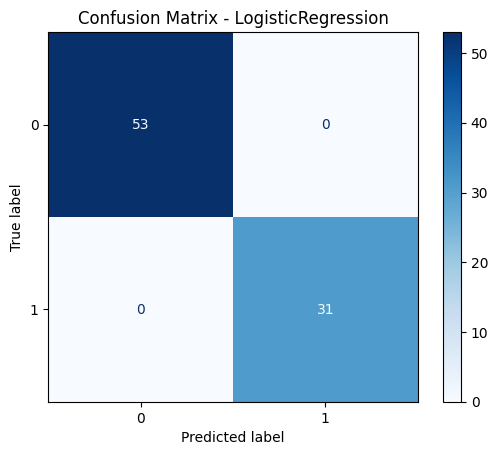

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Best model name (calculated in Step 2)
best_name = results_df.loc[0, "Model"]
best_model = trained_models[best_name]

print("Best model selected:", best_name)

# Predictions
preds = best_model.predict(X_test)

# Full Classification Report
print("\nCLASSIFICATION REPORT:\n")
print(classification_report(y_test, preds))

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, preds, cmap="Blues"
)
plt.title(f"Confusion Matrix - {best_name}")
plt.show()


  0%|          | 0/84 [00:00<?, ?it/s]

SHAP KernelExplainer summary (sampled):


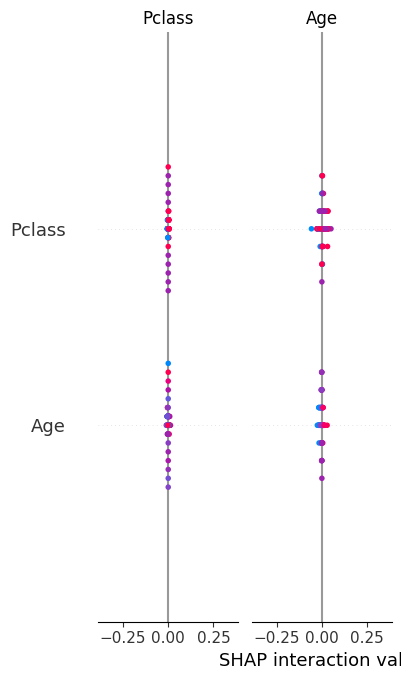

Explainability step complete.


In [11]:
# Step 4 — Explainability (SHAP if available, else feature importances / coefficients / permutation importance)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Safety checks
if 'best_model' not in globals():
    raise RuntimeError("best_model not found. Run the training cell first.")
if 'X_test' not in globals():
    raise RuntimeError("X_test not found. Run train/test split first.")

# Try SHAP first (recommended for tree models)
use_shap = True
try:
    import shap
except Exception as e:
    use_shap = False
    print("SHAP not installed or failed to import. Falling back to feature importances. (To install: !pip install shap)")

# If SHAP is available, attempt to create a Tree or Kernel explainer as appropriate
if use_shap:
    try:
        # For tree-based models TreeExplainer is fastest
        if hasattr(best_model, "predict_proba") and (hasattr(best_model, "feature_importances_") or best_model.__class__.__name__.lower().startswith(("randomforest","gradientboost","xgboost","lgbm","catboost"))):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test)
            # shap_values for binary classification is typically a list [neg, pos]
            # show bar summary for positive class if list
            if isinstance(shap_values, list):
                print("SHAP summary (bar) for positive class:")
                shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=True)
            else:
                print("SHAP summary (bar):")
                shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
        else:
            # Fallback to KernelExplainer for non-tree models (slower)
            explainer = shap.KernelExplainer(best_model.predict_proba if hasattr(best_model, "predict_proba") else best_model.predict, shap.sample(X_train, min(100, len(X_train))))
            shap_values = explainer.shap_values(shap.sample(X_test, min(100, len(X_test))))
            print("SHAP KernelExplainer summary (sampled):")
            # shap_values may be list
            if isinstance(shap_values, list):
                shap.summary_plot(shap_values[1], shap.sample(X_test, min(100, len(X_test))), plot_type="bar", show=True)
            else:
                shap.summary_plot(shap_values, shap.sample(X_test, min(100, len(X_test))), plot_type="bar", show=True)
    except Exception as e:
        print("SHAP failed:", e)
        use_shap = False

# If SHAP not used or failed, use other explainability methods
if not use_shap:
    # 1) If model exposes feature_importances_ (tree models), use them
    if hasattr(best_model, "feature_importances_"):
        importances = pd.Series(best_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
        print("Top 20 feature importances (model.feature_importances_):")
        display(importances.head(20))
        plt.figure(figsize=(6,8))
        importances.head(20).plot(kind="barh")
        plt.gca().invert_yaxis()
        plt.title("Feature importances")
        plt.tight_layout()
        plt.show()

    # 2) If it's a linear model with coef_, show coefficients
    elif hasattr(best_model, "coef_"):
        coefs = pd.Series(best_model.coef_.ravel(), index=X_test.columns).sort_values(key=abs, ascending=False)
        print("Top 20 coefficients (abs sorted):")
        display(coefs.head(20))
        plt.figure(figsize=(6,8))
        coefs.head(20).plot(kind="barh")
        plt.gca().invert_yaxis()
        plt.title("Model coefficients")
        plt.tight_layout()
        plt.show()

    # 3) Otherwise use permutation importance (model-agnostic)
    else:
        print("Using permutation importance (may be slower).")
        from sklearn.inspection import permutation_importance
        r = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
        perm_imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
        display(perm_imp.head(20))
        plt.figure(figsize=(6,8))
        perm_imp.head(20).plot(kind="barh")
        plt.gca().invert_yaxis()
        plt.title("Permutation importance (mean)")
        plt.tight_layout()
        plt.show()

print("Explainability step complete.")


In [12]:
import joblib, json, os

# Choose a save directory
save_dir = "/content"   # Colab default
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "titanic_model.pkl")
features_path = os.path.join(save_dir, "feature_names.json")

joblib.dump(best_model, model_path)

with open(features_path, "w") as f:
    json.dump(list(X.columns), f)

print("Saved model →", model_path)
print("Saved feature_names →", features_path)


Saved model → /content/titanic_model.pkl
Saved feature_names → /content/feature_names.json


In [14]:
import pandas as pd
import joblib, json

# Load saved model & feature names
loaded_model = joblib.load("/content/titanic_model.pkl")

with open("/content/feature_names.json", "r") as f:
    feature_names = json.load(f)

def run_inference(sample_raw):
    df_s = pd.DataFrame([sample_raw])

    # Engineered features
    df_s["family_size"] = df_s["SibSp"] + df_s["Parch"] + 1

    # FIXED: correct cabin_present logic
    df_s["cabin_present"] = df_s["Cabin"].notnull().astype(int)

    df_s["fare_per_person"] = df_s["Fare"] / df_s["family_size"]

    # Extract Title
    df_s["Title"] = df_s["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).fillna("Mr")

    # Columns needed
    use_cols = [
        "Pclass","Sex","Age","Fare","Embarked","Title",
        "family_size","cabin_present","fare_per_person"
    ]
    df_s = df_s[use_cols]

    # One-hot encode
    df_s = pd.get_dummies(df_s, columns=["Sex","Embarked","Title"], drop_first=True)

    # Align with training features
    for col in feature_names:
        if col not in df_s.columns:
            df_s[col] = 0

    df_s = df_s[feature_names]

    # Predict
    pred = loaded_model.predict(df_s)[0]
    prob = loaded_model.predict_proba(df_s)[0][1]

    return {
        "Prediction (0=Die, 1=Survive)": int(pred),
        "Survival Probability": float(prob)
    }

# Example input
sample = {
    "Name": "Doe, Mr. John",
    "Pclass": 3,
    "Sex": "male",
    "Age": 22,
    "SibSp": 1,
    "Parch": 0,
    "Fare": 7.25,
    "Embarked": "S",
    "Cabin": None
}

run_inference(sample)


{'Prediction (0=Die, 1=Survive)': 1,
 'Survival Probability': 0.8094090038325498}